Reference 
- [XGBoost for Multi-Step Univariate Time Series Forecasting with MultiOutputRegressor](https://xgboosting.com/xgboost-for-multi-step-univariate-time-series-forecasting-with-multioutputregressor/)
- [XGBoost for Time Series Classification](https://xgboosting.com/xgboost-for-time-series-classification/)
    - Using lagged features 

### Loading Data

In [1]:
import os
import pandas as pd
import numpy as np

def load_data_from_files(data_dir):
    all_data = []
    for filename in os.listdir(data_dir):
        if filename.endswith('.csv'):
            # Extract metadata from filename
            collection_id, step_info, _ = filename.split('_', 2)
            step_number = ''.join(filter(str.isdigit, step_info))
            foot = 'R' if 'R' in step_info else 'L'
            filepath = os.path.join(data_dir, filename)

            df = pd.read_csv(filepath) 

            df['collection_id'] = collection_id + '_' + str(step_number) + '_' + foot  
            df['filename'] = filename  # Keep track of the file
            df['time'] = pd.to_datetime(df['time'])  # Ensure 'time' column is in datetime format
            df['elapsed_time'] = (df['time'] - df['time'].min()).dt.total_seconds()
            df['gyroscope_magnitude'] = np.sqrt(df['gyroscope_x']**2 + df['gyroscope_y']**2 + df['gyroscope_z']**2)
            df['accelerometer_magnitude'] = np.sqrt(df['accelerometer_x']**2 + df['accelerometer_y']**2 + df['accelerometer_z']**2)
            cols = ['collection_id', 'elapsed_time', 'gyroscope_x', 'gyroscope_y', 
                    'gyroscope_z', 'accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'phase', 'gyroscope_magnitude', 'accelerometer_magnitude'] # , 'foot', 'filename']
            df = df[cols] 
            # df = df[df['phase'] != 0]
            all_data.append(df) 
    return pd.concat(all_data, ignore_index=True)

data_dir = '../csv_output_with_phases'  # Replace with your directory
data = load_data_from_files(data_dir) 

###  Visualize the magnitude of the gyroscope data for three random collection_ids

choosing 3 random data sets. 

In [2]:
# Filter data for the first 3 collection_ids and remove rows with null values
first_three_collection_ids = np.random.choice(data['collection_id'].unique(), 3, replace=False)
first_three_collection_data = data[data['collection_id'].isin(first_three_collection_ids)].dropna()

**assessing the autocorrelation of the target data using ACF ( Autocorrelation Function )**  
The ACF plot shows the non-stationarity of the data, which allows us to use time series techniques such as lagged features or windowed data; the targets are correlated over time.   
The blue region shows the 95% confidence interval of the correlation, thus the points that are outside of the blue region are statistically significant.   
The cut-off point is where the ACF curve crosses the blue line, and the lag at which the ACF curve crosses the blue line is the optimal lag; choose the lag size between 15~20. 

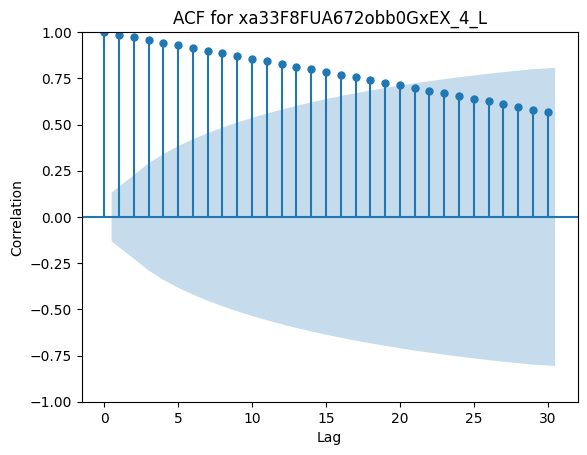

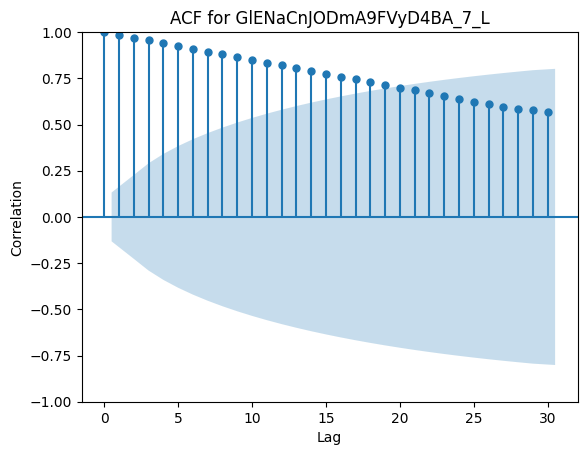

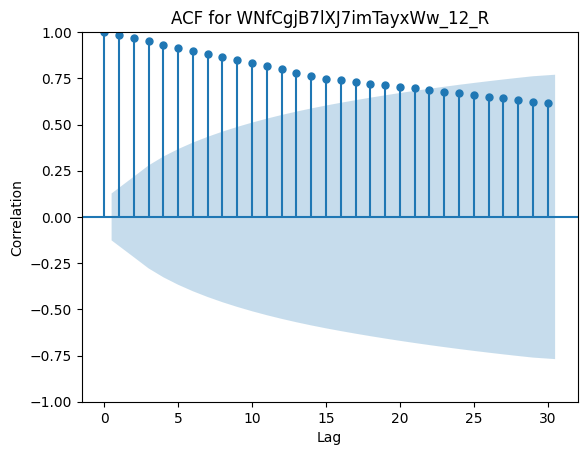

In [3]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

lag = 30

for collection_id in first_three_collection_ids:
    first_target = first_three_collection_data[first_three_collection_data['collection_id'] == collection_id]['phase']
    plot_acf(first_target, lags=lag, title = f"ACF for {collection_id}")
    plt.xlabel("Lag")
    plt.ylabel("Correlation")
    plt.show()


The result is backed up by calculating the magnitude of the gyroscope data, which can describe the gait cycle.  
One can observe that the gait cycle is related to the time. 


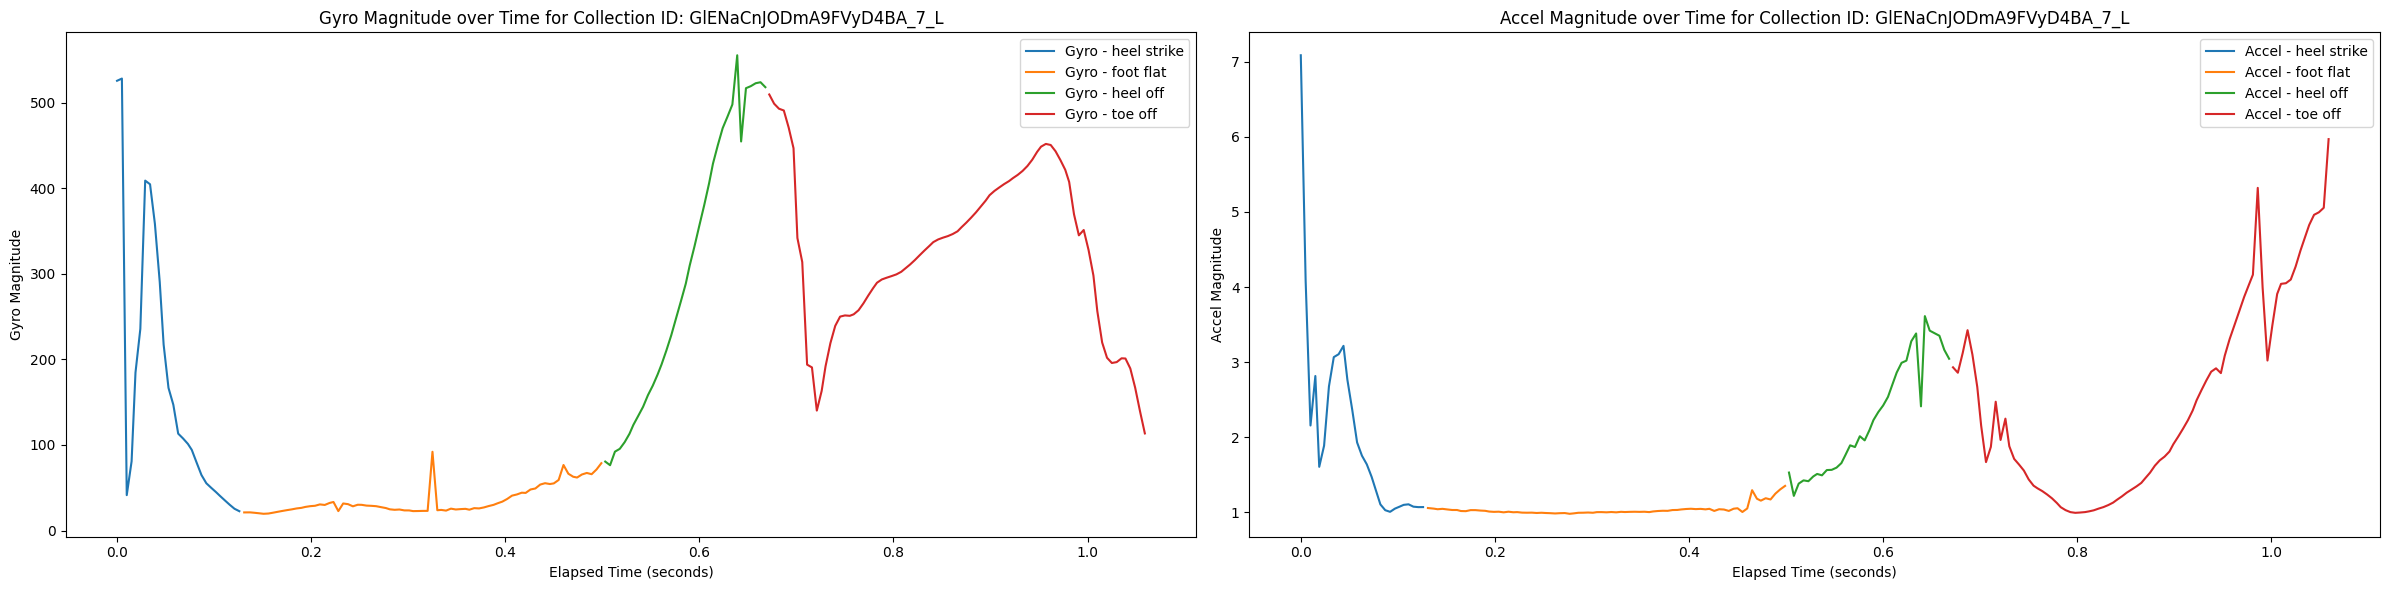

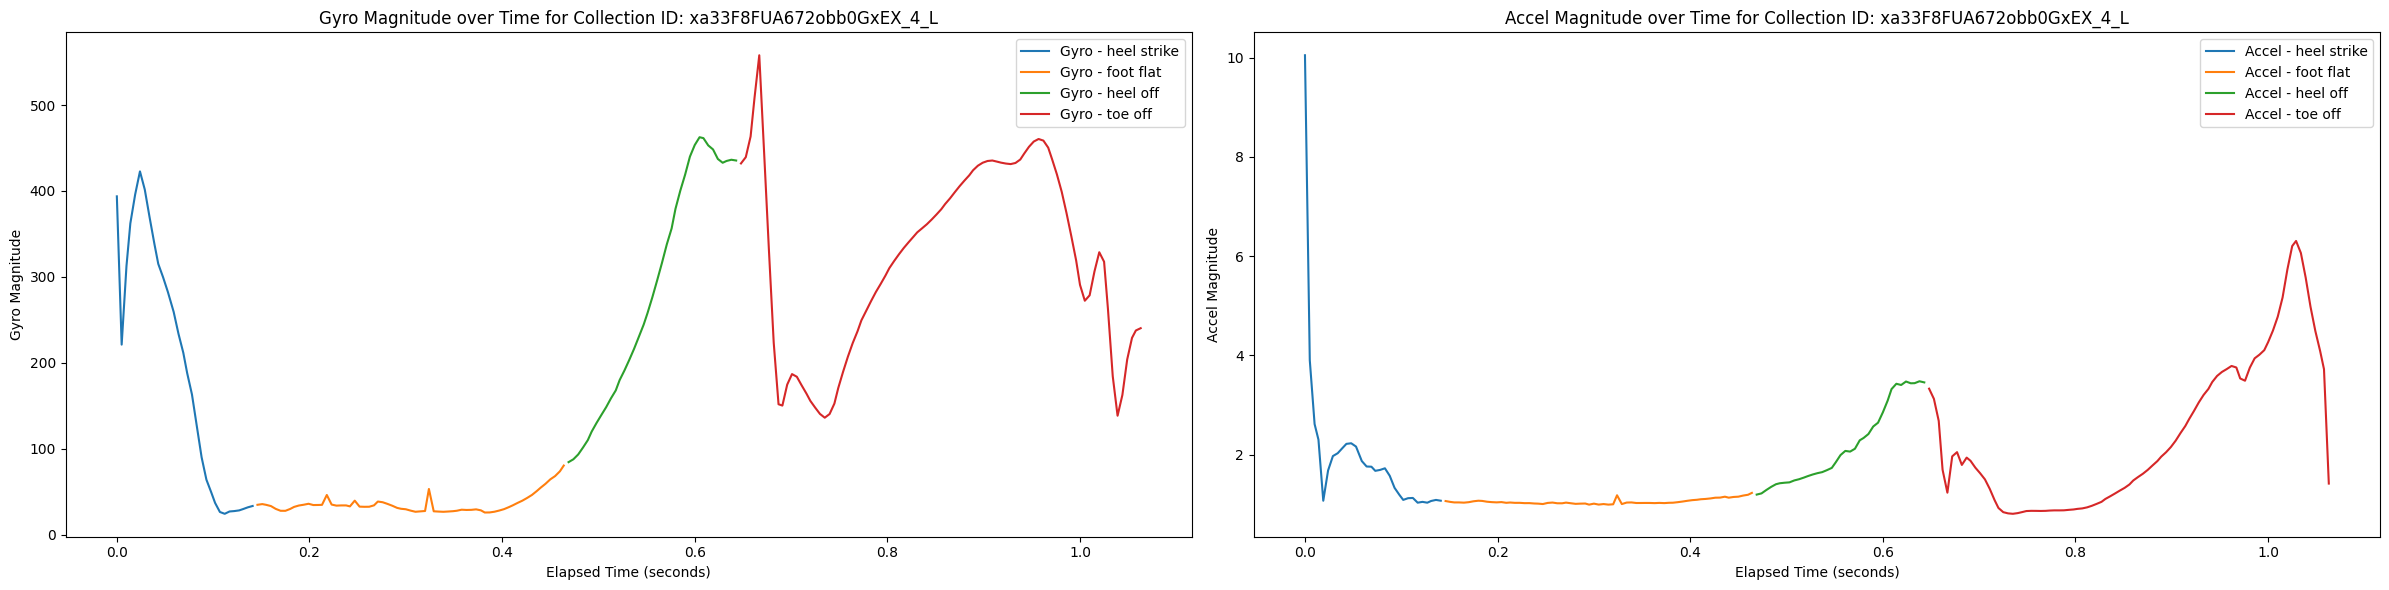

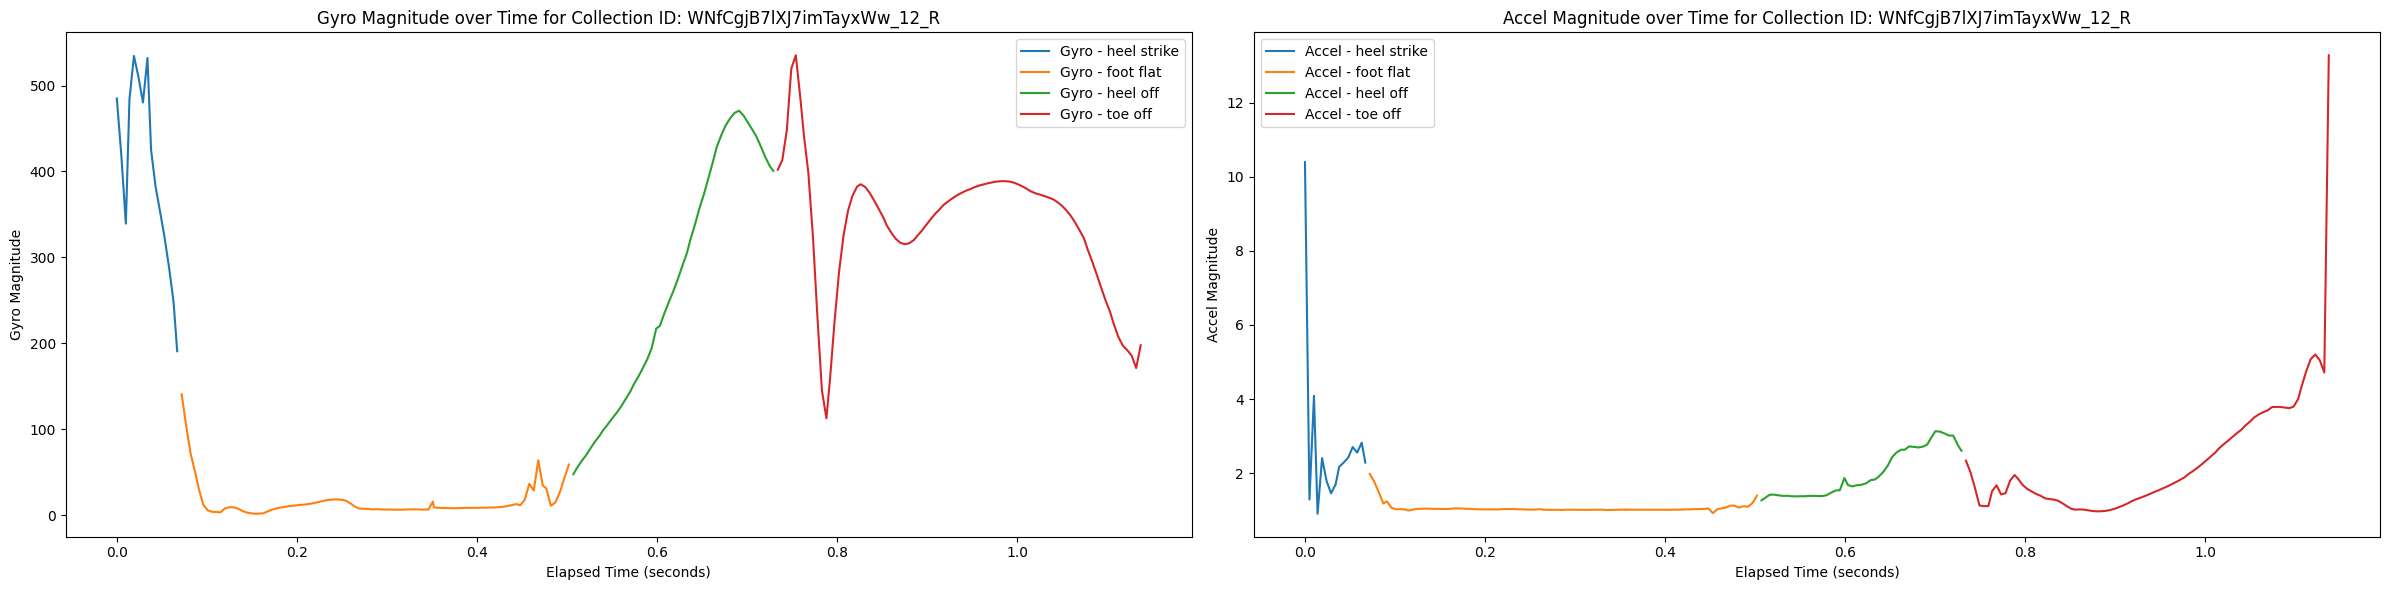

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Define phase labels
phase_labels = {
    0: 'no event',
    1: 'heel strike',
    2: 'foot flat',
    3: 'heel off',
    4: 'toe off'
}

# Iterate over each collection_id
collection_ids = first_three_collection_data['collection_id'].unique()

for collection_id in collection_ids:
    collection_data = first_three_collection_data[first_three_collection_data['collection_id'] == collection_id]
    
    # Create subplots for gyro_magnitude and accel_magnitude
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))
    
    # Plot gyro_magnitude over time for each collection_id with different colors for each phase
    phases = collection_data['phase'].unique()
    for phase in phases:
        phase_data = collection_data[collection_data['phase'] == phase]
        ax1.plot(phase_data['elapsed_time'], phase_data['gyroscope_magnitude'], label=f'Gyro - {phase_labels[phase]}')

    ax1.set_xlabel('Elapsed Time (seconds)')
    ax1.set_ylabel('Gyro Magnitude')
    ax1.set_title(f'Gyro Magnitude over Time for Collection ID: {collection_id}')
    ax1.legend()

    # Plot accel_magnitude over time for each collection_id with different colors for each phase
    for phase in phases:
        phase_data = collection_data[collection_data['phase'] == phase]
        ax2.plot(phase_data['elapsed_time'], phase_data['accelerometer_magnitude'], label=f'Accel - {phase_labels[phase]}')

    ax2.set_xlabel('Elapsed Time (seconds)')
    ax2.set_ylabel('Accel Magnitude')
    ax2.set_title(f'Accel Magnitude over Time for Collection ID: {collection_id}')
    ax2.legend()

    plt.tight_layout()
    plt.show()

### Preprocess data 
Scale the features and encode the target labels 

In [5]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

def preprocess_data(data):
    # Define features and target
    features = ['gyroscope_x', 'gyroscope_y', 'gyroscope_z',
                'accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'gyroscope_magnitude', 'accelerometer_magnitude']
    target = 'phase'

    # Drop rows with missing values
    data = data.dropna(subset=features + [target])

    # Normalize features
    scaler = MinMaxScaler()
    data.loc[:, features] = scaler.fit_transform(data[features])

    # Encode target labels
    label_encoder = LabelEncoder()
    data.loc[:, target] = label_encoder.fit_transform(data[target])

    return data, label_encoder

In [6]:
scaled_data, label_encoder = preprocess_data(data)

In [7]:
print(scaled_data['phase'].unique())

[1 2 3 4 0]


### Lagged data preparation 
Data Should be reshaped to 2D 
- [StackOverflow](https://stackoverflow.com/questions/61550147/xgboost-use-3-dimensional-input-containing-time-steps-in-python) : Suggests to add labels to each sequences to distinguish one sequence from another, which will also be learned by the model. 
- [StackOverflow](https://stackoverflow.com/questions/68292862/performancewarning-dataframe-is-highly-fragmented-this-is-usually-the-result-o) : Pandas Performance Warning Issue 

Time steps shold include one whole cycle. From the gyro magnitude plot, it is clear that one pattern ranges from 200ms ~ 400ms, which means that around 50 lags are needed to capture one whole cycle, given that the sampling rate is 100Hz.

In [8]:
class Windowed_DataSet:
    def __init__(self, data, features, target, sequence_length=50): 
        self.data = data 
        self.features = features 
        self.target = target 
        self.sequence_length = sequence_length 
        
        self.sequences = [] 
        self.labels = [] 
        collection_number = 0 

        for collection_id in self.data['collection_id'].unique():
            collection_data = self.data[self.data['collection_id'] == collection_id].sort_values(by='elapsed_time')
            collection_length = len(collection_data)
            collection_number += 1 
            sequence_number = 0 
            if collection_length > self.sequence_length: 
                for i in range(collection_length - self.sequence_length + 1):
                    seq = collection_data.iloc[i:i+self.sequence_length].copy()
                    seq['collection_number'] = int(collection_number)  
                    seq['sequence_number'] = int(sequence_number)  
                    self.sequences.append(seq[self.features + ['collection_number', 'sequence_number']].values)  
                    self.labels.append([seq[self.target].values[-1]] * len(seq))
                    sequence_number += 1 

        self.sequences = np.array(self.sequences)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        x = self.sequences[idx]
        y = self.labels[idx]
        return x, y 



class Lagged_DataSet():
    def __init__(self, data, features, target, window_size=50): 
        self.data = data 
        self.features = features 
        self.len_features = len(self.features) 
        self.target = target 
        self.window_size = window_size

        self.collection_id = 0

        self.X = pd.DataFrame()
        self.y = pd.DataFrame()

        # self.X_df = pd.DataFrame()
        # self.y_df = pd.DataFrame()
        
        for collection_id in self.data['collection_id'].unique():
            collection_data = self.data[self.data['collection_id'] == collection_id].sort_values(by='elapsed_time')
            collection_data = collection_data[self.features + ['phase']]
            collection_length = len(collection_data)
            if collection_length > self.window_size: 
                lagged_features = {}
                for j in range(self.len_features):
                    for i in range(1, self.window_size):
                        lagged_features[f'{self.features[j]}_lag{i}'] = collection_data[self.features[j]].shift(i)
                lagged_df = pd.DataFrame(lagged_features)
                collection_data = pd.concat([collection_data, lagged_df], axis=1)

            collection_data.dropna(inplace=True) 
            collection_data['collection_id'] = self.collection_id

            collection_data = collection_data.drop(columns=self.features)
            collection_data = collection_data.dropna(axis=1, how='any')
            
            self.X = pd.concat([self.X, collection_data.drop(columns=[self.target])], ignore_index=True)
            self.y = pd.concat([self.y, collection_data[[self.target]]], ignore_index=True)

            self.collection_id += 1  
        
        self.X_df = self.X.copy()
        self.y_df = self.y.copy()
        self.X = self.X.values
        self.y = self.y.values 

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        # return self.X.iloc[idx], self.y.iloc[idx] 
        return self.X[idx], self.y[idx] 

#### Data with the whole features 

In [9]:
features = ['gyroscope_x', 'gyroscope_y', 'gyroscope_z',
            'accelerometer_x', 'accelerometer_y', 'accelerometer_z']
target = 'phase'
sequence_length = 15  # hyperparameter to be tuned; 15~20 is optimal

dataset = Lagged_DataSet(scaled_data, features, target, sequence_length)

In [10]:
dataset.y_df[target].unique() # check if the target labels consist of 0 ~ 4 sequentially. 
print(len(dataset.X_df))
dataset.X_df

475910


,gyroscope_x_lag1,gyroscope_x_lag2,gyroscope_x_lag3,gyroscope_x_lag4,gyroscope_x_lag5,gyroscope_x_lag6,gyroscope_x_lag7,gyroscope_x_lag8,gyroscope_x_lag9,gyroscope_x_lag10,...,accelerometer_z_lag6,accelerometer_z_lag7,accelerometer_z_lag8,accelerometer_z_lag9,accelerometer_z_lag10,accelerometer_z_lag11,accelerometer_z_lag12,accelerometer_z_lag13,accelerometer_z_lag14,collection_id
0,0.542890,0.539653,0.539167,0.543968,0.537980,0.519691,0.477935,0.427924,0.391886,0.363185,...,0.474632,0.480505,0.479674,0.474859,0.477446,0.490814,0.563660,0.471328,0.219917,0
1,0.544346,0.542890,0.539653,0.539167,0.543968,0.537980,0.519691,0.477935,0.427924,0.391886,...,0.469817,0.474632,0.480505,0.479674,0.474859,0.477446,0.490814,0.563660,0.471328,0
2,0.548338,0.544346,0.542890,0.539653,0.539167,0.543968,0.537980,0.519691,0.477935,0.427924,...,0.467684,0.469817,0.474632,0.480505,0.479674,0.474859,0.477446,0.490814,0.563660,0
3,0.551683,0.548338,0.544346,0.542890,0.539653,0.539167,0.543968,0.537980,0.519691,0.477935,...,0.467835,0.467684,0.469817,0.474632,0.480505,0.479674,0.474859,0.477446,0.490814,0
4,0.552870,0.551683,0.548338,0.544346,0.542890,0.539653,0.539167,0.543968,0.537980,0.519691,...,0.475916,0.467835,0.467684,0.469817,0.474632,0.480505,0.479674,0.474859,0.477446,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475905,0.465230,0.460941,0.472513,0.498759,0.532639,0.565953,0.586076,0.592900,0.587478,0.575097,...,0.510791,0.504116,0.497649,0.491900,0.485508,0.477719,0.467155,0.454835,0.447386,2323
475906,0.481495,0.465230,0.460941,0.472513,0.498759,0.532639,0.565953,0.586076,0.592900,0.587478,...,0.514643,0.510791,0.504116,0.497649,0.491900,0.485508,0.477719,0.467155,0.454835,2323
475907,0.504748,0.481495,0.465230,0.460941,0.472513,0.498759,0.532639,0.565953,0.586076,0.592900,...,0.515729,0.514643,0.510791,0.504116,0.497649,0.491900,0.485508,0.477719,0.467155,2323
475908,0.527163,0.504748,0.481495,0.465230,0.460941,0.472513,0.498759,0.532639,0.565953,0.586076,...,0.515691,0.515729,0.514643,0.510791,0.504116,0.497649,0.491900,0.485508,0.477719,2323


## XGBoost for Time Series Classification  

### Split the dataset into training and test sets

In [11]:
from sklearn.model_selection import train_test_split 
import xgboost as xgb 

random_state = 42 

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(dataset.X, dataset.y, test_size=0.2, random_state=random_state)

In [12]:
print(f"Training set size, X:{len(X_train)}, y: {len(y_train)}")
print(f"Test set size, X: {len(X_test)}, y: {len(y_test)}")

Training set size, X:380728, y: 380728
Test set size, X: 95182, y: 95182


### Building an initial model 
- Make sure X_train is a 2D array and y_train is a 1D array to use DMatrix
- The data should be a float32 or float64 type to use DMatrix

In [13]:
dtrain = xgb.DMatrix(data=X_train, label=y_train.ravel())
dtest = xgb.DMatrix(data=X_test, label=y_test.ravel())

wlist = [(dtrain, 'train'), (dtest, 'eval')]

params = {
    'max_depth': 10,
    'eta': 0.1,
    'objective': 'multi:softmax',
    'eval_metric': 'mlogloss',
    'num_class': len(np.unique(y_train)),
    'seed': 42
}

num_rounds = 400

In [14]:
print(f"The datatype of X_train is: {type(X_train)}")
print(f"The data type of the elements in X_train is: {X_train.dtype}")
print(f"The data type of the elements in X_train is: {y_train.dtype}")

The datatype of X_train is: <class 'numpy.ndarray'>
The data type of the elements in X_train is: float64
The data type of the elements in X_train is: int64


In [15]:
model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds, early_stopping_rounds=100, evals=wlist)

[0]	train-mlogloss:1.40796	eval-mlogloss:1.40996
[1]	train-mlogloss:1.25041	eval-mlogloss:1.25420
[2]	train-mlogloss:1.12190	eval-mlogloss:1.12731
[3]	train-mlogloss:1.01437	eval-mlogloss:1.02124
[4]	train-mlogloss:0.92279	eval-mlogloss:0.93101
[5]	train-mlogloss:0.84367	eval-mlogloss:0.85309
[6]	train-mlogloss:0.77483	eval-mlogloss:0.78538
[7]	train-mlogloss:0.71413	eval-mlogloss:0.72588
[8]	train-mlogloss:0.66064	eval-mlogloss:0.67358
[9]	train-mlogloss:0.61335	eval-mlogloss:0.62739
[10]	train-mlogloss:0.57122	eval-mlogloss:0.58631
[11]	train-mlogloss:0.53366	eval-mlogloss:0.54983
[12]	train-mlogloss:0.50004	eval-mlogloss:0.51720
[13]	train-mlogloss:0.46968	eval-mlogloss:0.48782
[14]	train-mlogloss:0.44227	eval-mlogloss:0.46142
[15]	train-mlogloss:0.41764	eval-mlogloss:0.43771
[16]	train-mlogloss:0.39547	eval-mlogloss:0.41639
[17]	train-mlogloss:0.37545	eval-mlogloss:0.39725
[18]	train-mlogloss:0.35735	eval-mlogloss:0.38002
[19]	train-mlogloss:0.34084	eval-mlogloss:0.36438
[20]	train

In [16]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np


# Initialize the model
classifier_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y_train)))

# Train the model
classifier_model.fit(X_train, y_train)

# Evaluate the model
y_pred = classifier_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.9212
F1 Score: 0.8005
Precision: 0.8563
Recall: 0.7679


In [17]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report 

y_pred = classifier_model.predict(X_test)

# Define all possible labels
labels = range(len(np.unique(y_train)))  # Ensure num_classes is set correctly (should be 5)

# Manually define class names
class_names = ['no event', 'heel strike', 'foot flat', 'heel off', 'toe off']

print(classification_report(y_test, y_pred, labels=labels, target_names=class_names))
# print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

    no event       0.72      0.38      0.49       368
 heel strike       0.82      0.72      0.77      3015
   foot flat       0.91      0.94      0.93     34272
    heel off       0.86      0.83      0.85     19578
     toe off       0.97      0.97      0.97     37949

    accuracy                           0.92     95182
   macro avg       0.86      0.77      0.80     95182
weighted avg       0.92      0.92      0.92     95182



### Only with the gyroscope magnitude feature 


In [18]:
magnitude_features = ['gyroscope_magnitude']
target = 'phase'
sequence_length = 15  # hyperparameter to be tuned; 15~20 is optimal

gyro_dataset = Lagged_DataSet(scaled_data, magnitude_features, target, sequence_length)
gyro_dataset.y_df[target].unique() # check if the target labels consist of 0 ~ 4 sequentially. 
print(len(gyro_dataset.X_df))
gyro_dataset.X_df

475910


,gyroscope_magnitude_lag1,gyroscope_magnitude_lag2,gyroscope_magnitude_lag3,gyroscope_magnitude_lag4,gyroscope_magnitude_lag5,gyroscope_magnitude_lag6,gyroscope_magnitude_lag7,gyroscope_magnitude_lag8,gyroscope_magnitude_lag9,gyroscope_magnitude_lag10,gyroscope_magnitude_lag11,gyroscope_magnitude_lag12,gyroscope_magnitude_lag13,gyroscope_magnitude_lag14,collection_id
0,0.153134,0.165581,0.180252,0.203732,0.241761,0.286212,0.330723,0.371270,0.395103,0.406135,0.383989,0.353653,0.291461,0.242176,0
1,0.133764,0.153134,0.165581,0.180252,0.203732,0.241761,0.286212,0.330723,0.371270,0.395103,0.406135,0.383989,0.353653,0.291461,0
2,0.112334,0.133764,0.153134,0.165581,0.180252,0.203732,0.241761,0.286212,0.330723,0.371270,0.395103,0.406135,0.383989,0.353653,0
3,0.095144,0.112334,0.133764,0.153134,0.165581,0.180252,0.203732,0.241761,0.286212,0.330723,0.371270,0.395103,0.406135,0.383989,0
4,0.084812,0.095144,0.112334,0.133764,0.153134,0.165581,0.180252,0.203732,0.241761,0.286212,0.330723,0.371270,0.395103,0.406135,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475905,0.222731,0.243040,0.257566,0.268357,0.282120,0.298570,0.323722,0.342857,0.354692,0.362477,0.366200,0.365623,0.360632,0.354066,2323
475906,0.200684,0.222731,0.243040,0.257566,0.268357,0.282120,0.298570,0.323722,0.342857,0.354692,0.362477,0.366200,0.365623,0.360632,2323
475907,0.184465,0.200684,0.222731,0.243040,0.257566,0.268357,0.282120,0.298570,0.323722,0.342857,0.354692,0.362477,0.366200,0.365623,2323
475908,0.180135,0.184465,0.200684,0.222731,0.243040,0.257566,0.268357,0.282120,0.298570,0.323722,0.342857,0.354692,0.362477,0.366200,2323


In [19]:
from sklearn.model_selection import train_test_split 
import xgboost as xgb 

random_state = 42 

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(gyro_dataset.X, gyro_dataset.y, test_size=0.2, random_state=random_state)

In [20]:
gyro_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds, early_stopping_rounds=100, evals=wlist)

[0]	train-mlogloss:1.40796	eval-mlogloss:1.40996
[1]	train-mlogloss:1.25041	eval-mlogloss:1.25420
[2]	train-mlogloss:1.12190	eval-mlogloss:1.12731
[3]	train-mlogloss:1.01437	eval-mlogloss:1.02124
[4]	train-mlogloss:0.92279	eval-mlogloss:0.93101
[5]	train-mlogloss:0.84367	eval-mlogloss:0.85309
[6]	train-mlogloss:0.77483	eval-mlogloss:0.78538
[7]	train-mlogloss:0.71413	eval-mlogloss:0.72588
[8]	train-mlogloss:0.66064	eval-mlogloss:0.67358
[9]	train-mlogloss:0.61335	eval-mlogloss:0.62739
[10]	train-mlogloss:0.57122	eval-mlogloss:0.58631
[11]	train-mlogloss:0.53366	eval-mlogloss:0.54983
[12]	train-mlogloss:0.50004	eval-mlogloss:0.51720
[13]	train-mlogloss:0.46968	eval-mlogloss:0.48782
[14]	train-mlogloss:0.44227	eval-mlogloss:0.46142
[15]	train-mlogloss:0.41764	eval-mlogloss:0.43771
[16]	train-mlogloss:0.39547	eval-mlogloss:0.41639
[17]	train-mlogloss:0.37545	eval-mlogloss:0.39725
[18]	train-mlogloss:0.35735	eval-mlogloss:0.38002
[19]	train-mlogloss:0.34084	eval-mlogloss:0.36438
[20]	train

In [21]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np


# Initialize the model
classifier_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y_train)))

# Train the model
classifier_model.fit(X_train, y_train)

# Evaluate the model
y_pred = classifier_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.8824
F1 Score: 0.7175
Precision: 0.8172
Recall: 0.6760


In [22]:
classifier_model.max_depth

In [23]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report 

y_pred = classifier_model.predict(X_test)

# Define all possible labels
labels = range(len(np.unique(y_train)))  # Ensure num_classes is set correctly (should be 5)

# Manually define class names
class_names = ['no event', 'heel strike', 'foot flat', 'heel off', 'toe off']

print(classification_report(y_test, y_pred, labels=labels, target_names=class_names))
# print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

    no event       0.74      0.24      0.36       368
 heel strike       0.74      0.52      0.61      3015
   foot flat       0.88      0.92      0.90     34272
    heel off       0.81      0.74      0.77     19578
     toe off       0.93      0.95      0.94     37949

    accuracy                           0.88     95182
   macro avg       0.82      0.68      0.72     95182
weighted avg       0.88      0.88      0.88     95182



[TODO] 
- Review if it is correctly implemented for the task  
- Corss Validation 
- Hyperparameter Tuning 
- Feature Engineering 
- Documentation

Experiment 
- Implementing experiment tracking with other tools such as Kedro 
- Investigate the duration of each phase of the gait cycle
    - implement different window size for each phase   

Reference :  
XGBoost theory  :   
- [About XGBoost - In Korean](https://zephyrus1111.tistory.com/232)

XGBoost practical examples :   
- [XGBoost for Multi-Step Univariate Time Series Forecasting with MultiOutputRegressor](https://xgboosting.com/xgboost-for-multi-step-univariate-time-series-forecasting-with-multioutputregressor/)  
- [XGBoost for Time Series Classification](https://xgboosting.com/xgboost-for-time-series-classification/)
    - Using lagged features   

Fixing Errors with windows data  : 
- [StackOverflow](https://stackoverflow.com/questions/61550147/xgboost-use-3-dimensional-input-containing-time-steps-in-python) : Suggests to add labels to each sequences to distinguish one sequence from another, which will also be learned by the model. 
- [StackOverflow](https://stackoverflow.com/questions/68292862/performancewarning-dataframe-is-highly-fragmented-this-is-usually-the-result-o) : Pandas Performance Warning Issue   

[Fixed 07 / Jan / 2025] 
- Plot 
    - The weird behavior was 

---